# Cassava RAPIDS kNN

**The RAPIDS suite from NVIDIA is a collection of libraries that allows you to perform end-to-end data science pipelines entirely on GPUs. Leading Kaggle solutions and higher performing models/solutions rely on iterations; the more you can iterate and experiment, the more optimal solution you will find, so ensuring a fast pipeline is key. We can easily do this with RAPIDS libraries like `cuDF` and `cuML`. We will focus on the `cuML` library in this notebook, using `cuML KNN` for inference, and `cuML KMeans / T-SNE` to visualize how our data is clustered.**

**We will extract image embeddings with EfficientNets and then use these CNN embeddings to train a RAPIDS cuML kNN to find similar images to see how kNN performs compared to more advanced models, like deep CNNs. This kernel is entirely motivated by [Chris Deotte](https://www.kaggle.com/cdeotte)'s notebook [here](https://www.kaggle.com/cdeotte/rapids-cuml-knn-find-duplicates) from the Melanoma competition, in which he uses this technique to find duplicate images. Before giving this notebook an upvote (if you intend to), please give his one first.**

**Note that I am using [Dimitre](https://www.kaggle.com/dimitreoliveira)'s TFRecords that can be found [here](https://www.kaggle.com/dimitreoliveira/cassava-leaf-disease-tfrecords-512x512). He also has 128x128, 256x256, and 384x384 sized images that I added for experimental purposes. Please give his datasets an upvote (and his work in general, it is excellent).**

In [1]:
import sys
sys.path.append('/kaggle/input/efficientnet-keras-dataset/efficientnet_kaggle')
from efficientnet.tfkeras import *

In [2]:
from matplotlib import pyplot as plt
import math, os, cv2, gc, re
import numpy as np, pandas as pd
from time import time
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import KFold

import tensorflow as tf
import tensorflow.keras.backend as K

# I. Configuration

In [3]:
DEVICE = 'GPU'

if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Using default strategy for CPU and single GPU
Num GPUs Available:  1
REPLICAS: 1


In [4]:
SEED = 34 
             
IMAGE_SIZE = [256, 256]               

BATCH_SIZE = 16 * REPLICAS 

FOLDS = 5

VERBOSE = 1

# II. Dataset Functions

**Note that we are using `noisy-student` pretrained weights, so we need to normalize our inputs by subtracting ImageNet mean `.449`and dividing by standard deviation `.226`. We must do this because the EfficientNet is not being trained anymore: if it was, the models weights would correct themselves. You can experiment with training on Cassava data before extracting embeddings: you will get different features and perhaps they will do better than just ImageNet pretraining.**

In [5]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = ((tf.cast(image, tf.float32) / 255.0) - 0.449) / 0.226     
    #image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_labeled_tfrecord(example, return_image_name):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        "target": tf.io.FixedLenFeature([], tf.int64), 
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['target'], tf.int32)
    img_name = example['image_name']
    
    if return_image_name:
        return image, label, img_name
    else:
        return image, label

def read_unlabeled_tfrecord(example, return_image_name):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "id": tf.io.FixedLenFeature([], tf.string), 
    }
    
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum if return_image_name else 0

def get_dataset(files, shuffle=False, repeat=False, labeled=True, return_image_names=True,
                batch_size=BATCH_SIZE, dim=IMAGE_SIZE[0]):
   
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)

    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(2048)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(lambda example: read_labeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)  
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)  

    ds = ds.batch(batch_size)
    ds = ds.prefetch(AUTO)
    
    return ds

def load_image(jpeg_path, image_id):  
    img = ((cv2.imread(os.path.join(jpeg_path, image_id))/255.0) - .449) / .226
    #img = cv2.imread(os.path.join(jpeg_path, image_id))/255.0
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]))[:, :, ::-1]
    return img

def generator(filepath, paths, batch_size=BATCH_SIZE):
    i=0
    while i <= len(paths):
        batch = []
        for cpt in range(batch_size):
            if i + cpt >= len(paths):
                i += batch_size
                break
            batch.append(load_image(filepath, paths[i+cpt]))
            
        i += batch_size
        yield np.stack(batch)

def count_data_items(filenames):
    n = [int(re.compile(r'-([0-9]*)\.').search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [6]:
TRAINING_FILENAMES =  tf.io.gfile.glob(f'../input/cassava-leaf-disease-tfrecords-{IMAGE_SIZE[0]}x{IMAGE_SIZE[0]}' + '/*.tfrec')
TRAINING_FILENAMES_ORG = tf.io.gfile.glob('../input/cassava-leaf-disease-classification/train_tfrecords' + '/*.tfrec')
TEST_JPEG_PATH = "../input/cassava-leaf-disease-classification/test_images"

submission = pd.read_csv('../input/cassava-leaf-disease-classification/sample_submission.csv')

# III. RAPIDS cuML kNN

**Now we can extract image embeddings with an EfficientNet and use RAPIDS cuML kNN for quick GPU model training. The kNN training doesn't take long at all, it is the feature extraction that takes a while. You can save the embeddings and upload them later to make the below loop faster.**

In [7]:
FINE_TUNE = True
FT_EPOCHS = 3

In [8]:
import cuml
print('RAPIDS version',cuml.__version__)

RAPIDS version 0.16.0


In [9]:
def efficientnet(b, image_size, head=False, LR=5e-4):
    efns = [EfficientNetB0, EfficientNetB1, EfficientNetB2,
            EfficientNetB3, EfficientNetB4, EfficientNetB5,
            EfficientNetB6]
    with strategy.scope():
        efficient = efns[b](
            input_shape=(image_size, image_size, 3),
            weights='noisy-student', #imagenet
            include_top=False
        )
        efficient.trainable=True
        
        if head:
            model = tf.keras.Sequential([
                efficient,
                tf.keras.layers.GlobalAveragePooling2D(name='pooling'), 
                tf.keras.layers.Dropout(.2), 
                tf.keras.layers.Dense(5, activation='softmax')
            ])
            
        else:
            model = tf.keras.Sequential([
                efficient,
                tf.keras.layers.GlobalAveragePooling2D()]) 
                
    if head: model.compile(optimizer=tf.keras.optimizers.Adam(LR), 
                           loss='sparse_categorical_crossentropy',
                           metrics=['sparse_categorical_accuracy'])
        
    return model

In [10]:
FOLDS = 5
SEED = 34
N_NEIGH = 10

In [11]:
skf = KFold(n_splits=FOLDS,shuffle=True,random_state=SEED)
preds_all = []
preds_model = []
oof_pred = []
oof_labels = []

for f, (train_index, val_index) in enumerate(skf.split(TRAINING_FILENAMES)):
    
    print('#'*30); print('#### FOLD',f+1); print('#'*30); print('')
    print('Getting datasets...'); print('')
    
    train_ds = get_dataset(list(pd.DataFrame({'TRAINING_FILENAMES': TRAINING_FILENAMES}).loc[train_index]['TRAINING_FILENAMES']),
                                            labeled=True, return_image_names=False, repeat=False, shuffle=False)
    val_ds = get_dataset(list(pd.DataFrame({'TRAINING_FILENAMES': TRAINING_FILENAMES}).loc[val_index]['TRAINING_FILENAMES']),
                                            labeled=True, return_image_names=False, repeat=False, shuffle=False)
    test_ds = generator(TEST_JPEG_PATH, submission.image_id.values)
    train_labs = [target.numpy() for img, target in iter(train_ds.unbatch())]
    val_labs = [target.numpy() for img, target in iter(val_ds.unbatch())]
    
    effnet_ = efficientnet(b=3, image_size=IMAGE_SIZE[0], head=FINE_TUNE)
    
    if FINE_TUNE:
        train_ds_ = get_dataset(list(pd.DataFrame({'TRAINING_FILENAMES': TRAINING_FILENAMES}).loc[train_index]['TRAINING_FILENAMES']),
                                            labeled=True, return_image_names=False, repeat=True, shuffle=True)
        
        print('Fine tuning EfficientNet...'); print('')
        ct_train = count_data_items(list(pd.DataFrame({'TRAINING_FILENAMES': TRAINING_FILENAMES}).loc[train_index]['TRAINING_FILENAMES']))
        effnet_.fit(train_ds_, 
                    validation_data=val_ds,
                    verbose=1, 
                    steps_per_epoch=ct_train//BATCH_SIZE,
                    epochs=FT_EPOCHS)
        print('')
        effnet = tf.keras.Model(inputs = effnet_.input, 
               outputs = effnet_.get_layer('pooling').output)

    else: effnet = effnet_

    print('Getting embeddings...'); print('')
    embed = effnet.predict(train_ds, verbose=1)
    embed_val = effnet.predict(val_ds, verbose=1)
    embed_test = effnet.predict(test_ds, verbose=1)
    np.save(f'embed_b4_{f}_{IMAGE_SIZE[0]}',embed.astype('float32'))
    np.save(f'embed_val_b4_{f}_{IMAGE_SIZE[0]}',embed_val.astype('float32'))
    
    print(''); print('Training and inferring...'); print('')
    model = cuml.neighbors.KNeighborsClassifier(n_neighbors=N_NEIGH)
    model.fit(embed, np.array(train_labs))
    print('Training and inference complete.'); print('')
    
    preds = model.predict_proba(embed_test)
    preds_model.append(preds) 
    
    acc = accuracy_score(model.predict(embed_val), np.array(val_labs))
    print(f'Fold {f + 1} accuracy: {acc}'); print('')
    
    oof_labels.append([target.numpy() for img, target in iter(val_ds.unbatch())])
    x_oof = val_ds.map(lambda image, image_name: image)
    oof_pred.append(model.predict(embed_val))
    
preds_model = np.stack(preds_model).mean(0)
preds_all.append(preds_model)
preds_all = np.stack(preds_all)

##############################
#### FOLD 1
##############################

Getting datasets...

Fine tuning EfficientNet...

Epoch 1/3
1069/1069 [==============================] - 290s 271ms/step - loss: 0.6384 - sparse_categorical_accuracy: 0.7742 - val_loss: 0.5674 - val_sparse_categorical_accuracy: 0.8093
Epoch 2/3
1069/1069 [==============================] - 290s 271ms/step - loss: 0.4566 - sparse_categorical_accuracy: 0.8413 - val_loss: 0.4798 - val_sparse_categorical_accuracy: 0.8373
Epoch 3/3
1069/1069 [==============================] - 288s 270ms/step - loss: 0.3693 - sparse_categorical_accuracy: 0.8712 - val_loss: 0.5635 - val_sparse_categorical_accuracy: 0.8231

Getting embeddings...

1/1 [==============================] - 0s 9ms/step

Training and inferring...

Training and inference complete.

Fold 1 accuracy: 0.8452909558308016

##############################
#### FOLD 2
##############################

Getting datasets...

Fine tuning EfficientNet...

Epoch 1/3
1069/1069 [

In [12]:
y_true = np.concatenate(oof_labels)
y_preds = np.concatenate(oof_pred)

print(classification_report(y_true, y_preds))
print(f"OOF accuracy score: {accuracy_score(y_true, y_preds)}")

              precision    recall  f1-score   support

           0       0.60      0.57      0.58      1086
           1       0.75      0.72      0.74      2189
           2       0.77      0.72      0.74      2386
           3       0.94      0.95      0.95     13158
           4       0.65      0.69      0.67      2576

    accuracy                           0.85     21395
   macro avg       0.74      0.73      0.74     21395
weighted avg       0.85      0.85      0.85     21395

OOF accuracy score: 0.8518345407805562


# IV. RAPIDS cuML KMeans

**The embeddings generated by the EfficientNetB4 are dimension `1792`, so each image is represented as a point in `1792` dimensional space. We can cluster these points together with a RAPIDS KMeans model and then view what the images in each cluster look like. For now, we will force `N_CLUSTERS == 5`.**

In [13]:
train_dummy = get_dataset(TRAINING_FILENAMES, labeled=True,
                         return_image_names=True, repeat=False, 
                         shuffle=False)
names = np.array([img_name.numpy().decode("utf-8") for img, label, img_name in iter(train_dummy.unbatch())])
labels = np.array([label.numpy() for img, label, img_name in iter(train_dummy.unbatch())])
train_full = get_dataset(TRAINING_FILENAMES, labeled=True,
                       return_image_names=False, repeat=False, 
                       shuffle=False)
embed_full = effnet.predict(train_full, verbose=1)

1338/1338 [==============================] - 65s 48ms/step


In [14]:
train = pd.DataFrame()
train['image_id'] = names
train['label'] = labels

In [15]:
N_CLUSTERS = 5
model = cuml.KMeans(n_clusters=N_CLUSTERS)
model.fit(embed_full)
train['cluster'] = model.labels_
train.head()

image_id  label  cluster
0   100042118.jpg      1        3
1  1009462599.jpg      3        0
2  1009845426.jpg      3        2
3  1012257169.jpg      4        3
4  1012804587.jpg      1        4

#########################
#### Cluster 0 of similar train images
#########################


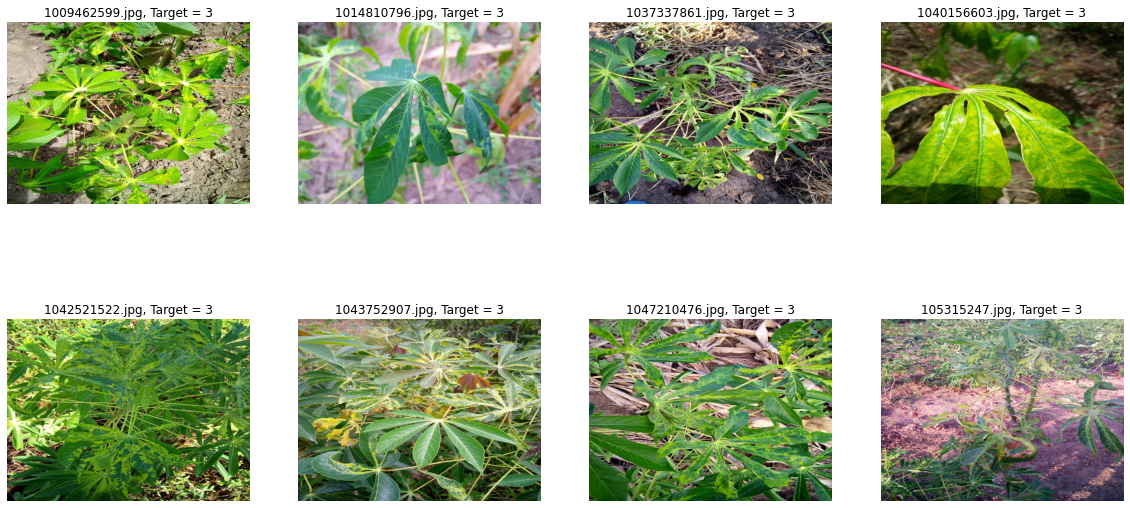

#########################
#### Cluster 1 of similar train images
#########################


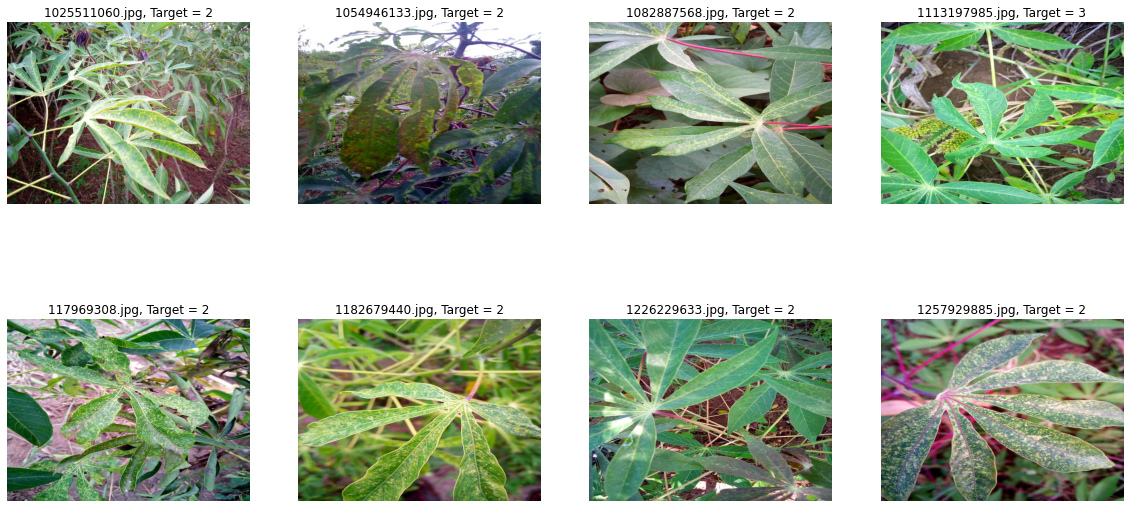

#########################
#### Cluster 2 of similar train images
#########################


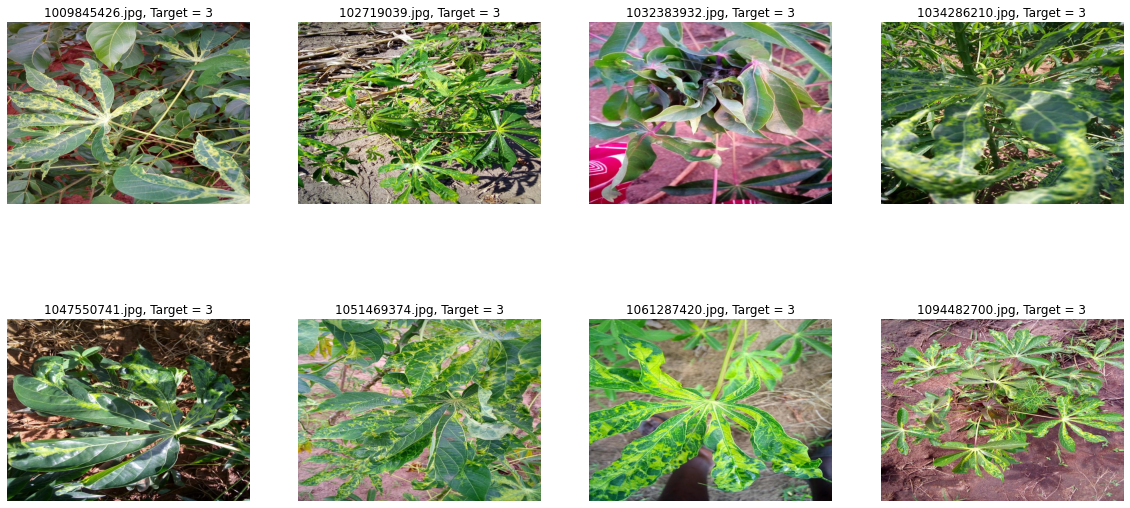

#########################
#### Cluster 3 of similar train images
#########################


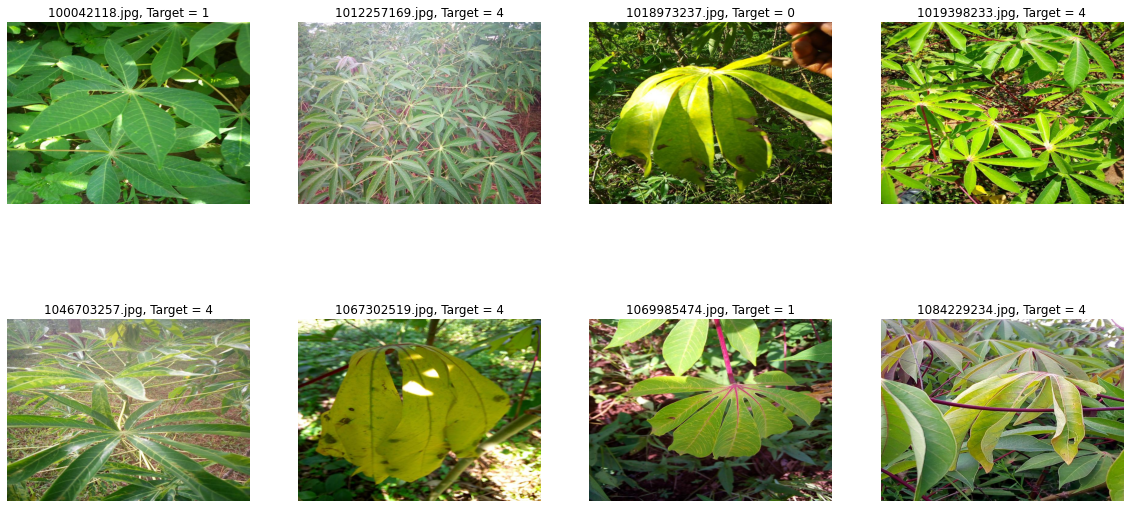

#########################
#### Cluster 4 of similar train images
#########################


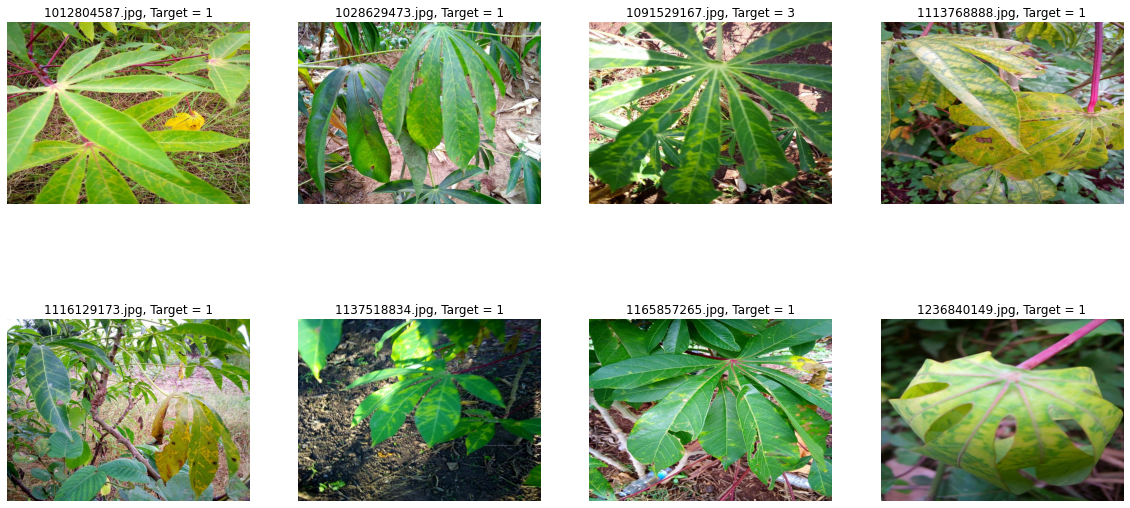

In [16]:
JPEG_TRAIN = '../input/cassava-leaf-disease-classification/train_images/'

for k in range(N_CLUSTERS):
    print('#'*25);
    print(f'#### Cluster {k} of similar train images')
    print('#'*25)
    df = train.loc[train.cluster==k]
    plt.figure(figsize=(20,10))
    for j in range(8):
        plt.subplot(2,4,j+1)
        img = cv2.imread(JPEG_TRAIN+names[df.index[j]])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.axis('off')
        plt.title(f"{names[df.index[j]]}, Target = {df.loc[df.index[j],'label']}")
        plt.imshow(img)  
    plt.show()

# V. RAPIDS cuML T-SNE

**We can of course also project these points in `1792` dimensional space to a 2 dimensional space to see how are samples are clustered. Forgive the ensuing mess of colors...**

In [17]:
PERPLEXITY = 5

In [18]:
model = cuml.TSNE(perplexity=PERPLEXITY)
embed2D = model.fit_transform(embed_full)
train['x'] = embed2D[:,0]
train['y'] = embed2D[:,1]

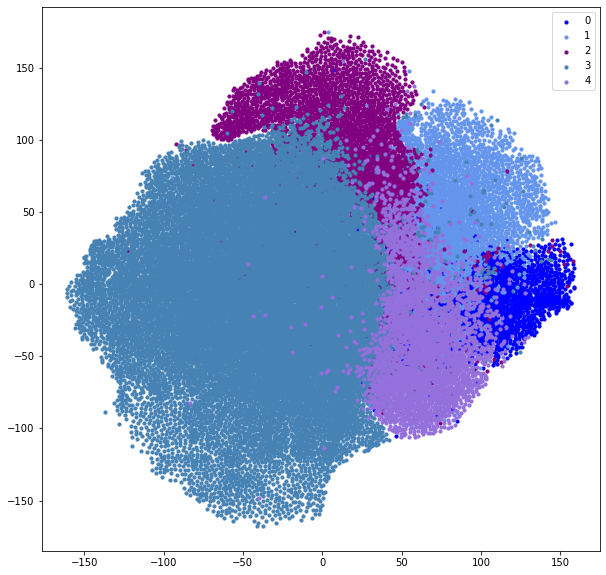

In [19]:
plt.figure(figsize=(10,10))
df1 = train.loc[train.label==0]
df2 = train.loc[train.label==1]
df3 = train.loc[train.label==2]
df4 = train.loc[train.label==3]
df5 = train.loc[train.label==4]

plt.scatter(df1.x,df1.y,c='blue',s=10,label='0')
plt.scatter(df2.x,df2.y,c='cornflowerblue',s=10,label='1')
plt.scatter(df3.x,df3.y,c='purple',s=10,label='2')
plt.scatter(df4.x,df4.y,c='steelblue',s=10,label='3')
plt.scatter(df5.x,df5.y,c='mediumpurple',s=10,label='4')
plt.legend();

# VI. Submission

In [20]:
print(preds_all.shape)
preds_all

(1, 1, 5)


array([[[0.02      , 0.        , 0.16000001, 0.        , 0.82000005]]],
      dtype=float32)

In [21]:
submission["label"] = preds_all.mean(0).argmax(1)
submission.to_csv("submission.csv", index=False)

In [22]:
submission

image_id  label
0  2216849948.jpg      4